# Splitpea - Condition-specific Mode

**Goal**: Use Splitpea to generate condition-specific rewired PPI networks from
rMATS and SUPPA2 differential splicing outputs, then run simple analysis using the rewired networks.


In [ ]:
#@title 0. Install and import dependencies

%%capture
!pip install --index-url https://test.pypi.org/simple/ \
            --extra-index-url https://pypi.org/simple splitpea

!sudo apt-get install tabix  # Tabix is used under-the-hood for some of the functions

!pip install gseapy

!wget https://raw.githubusercontent.com/ylaboratory/splitpea/master/reference/hsa_mapping_all.txt

import splitpea
import pandas as pd
import gseapy as gp
import numpy as np
import re

In [ ]:
!splitpea --help  # Splitpea can be run both as a command-line tool and as a Python library

usage: splitpea [-h]
                {run,plot,stats,calculate_delta_psi,combine_spliced_exon,preprocess_pooled,get_consensus_network}
                ...

splitpea: SPLicing InTeractions PErsonAlized

positional arguments:
  {run,plot,stats,calculate_delta_psi,combine_spliced_exon,preprocess_pooled,get_consensus_network}
    run                 calculate and output rewired network
    plot                load a saved rewired network (.edges.pickle) and
                        produce plots
    stats               compute and write gene level statistics for a rewired
                        splicing PPI network
    calculate_delta_psi
                        Calculate delta PSI values and p-values for background
                        vs compare exon comparisons
    combine_spliced_exon
                        Combine individual spliced-exon PSI files into a
                        single mean PSI file per exon
    preprocess_pooled   Download or use existing background psi files, com

## 1. Splitpea on rMATS


For this example, we use data downloaded from [Zenodo](https://zenodo.org/records/6647024). The dataset comes from the manuscript “rMATS-turbo: an efficient and flexible computational tool for alternative splicing analysis of large-scale RNA-seq data” by Wang et. al.

rMATS produces two alternative splicing event files for skipped exons (SE):  
- `SE.MATS.JCEC.txt` — counts both junction reads and reads spanning the exon body  
- `SE.MATS.JC.txt` — counts only junction reads  

Either file can be directly used as input to Splitpea as is. In this analysis, we specifically use `SE.MATS.JCEC.txt` as our input file from the **PC3E** and **GS689** cell line comparision (PC3E-GS689.tar.gz). ***Please upload this file to the notebook environment before running the following analysises.***

#### 1.1 Running Splitpea

To run Splitpea, call the `splitpea.run` function with three key arguments:  
1. the rMATS splicing output file as input,  
2. `differential_format="rmats"` to specify the file type, and  
3. an output prefix.  

You can also customize the run by adjusting additional parameters, such as modifying PSI and p-value filters for events to be considered or providing your own alternative reference files in place of the defaults. For a full list of options, see the package's [documentation](https://github.com/ylaboratory/splitpea_package).

This will generate two files:  
- `<out_file_prefix>.edges.dat`: a per-edge summary table  
- `<out_file_prefix>.edges.pickle`: a pickled NetworkX graph of the rewired network

In [ ]:
net1 = splitpea.run(
    in_file="/content/SE.MATS.JCEC.txt",
    differential_format="rmats",
    out_file_prefix="PC3E_GS689",
    verbose = True
)


INFO:diff_exon:Loading DDIs....
INFO:diff_exon:# pfams: 8602, # ddis: 17450
INFO:diff_exon:Loading PPIs....
INFO:diff_exon:# proteins: 20286, # interactions: 793078
INFO:diff_exon:Loading gene-protein domain info....
INFO:diff_exon:Reading differential exon results....
INFO:diff_exon:Reading in input exons...
INFO:diff_exon:# of differentially expressed exons: 20067
INFO:diff_exon:Calculating network....
INFO:diff_exon:# nodes: 6173, # edges: 17012
INFO:diff_exon:Outputting as pickle...
INFO:diff_exon:Temporary file /content/tmpi26k3vnx.txt deleted.
INFO:diff_exon:Done


#### 1.2 Getting rewired network statistics

After generating a rewired network with `splitpea.run`, we can compute per-gene and per-edge summary statistics using the `splitpea.stats` function.  

This function takes as input the `<prefix>.edges.dat` and `<prefix>.edges.pickle` files generated by `splitpea.run`. As output, it prints the total number of gain, loss, and chaos edges in the network and returns a DataFrame for per-node analysis. Each row corresponds to a gene and includes its Entrez ID, gene symbol, degree (the number of edges connected to the gene), normalized degree (the percentage of the maximum possible rewiring relative to the reference PPI), as well as the number of gain, loss, and chaos edges that the gene is involved in. The dataframe is sorted by degree.



In [ ]:
PC3E_GS689_stats = splitpea.stats("/content/PC3E_GS689.edges.dat", "/content/PC3E_GS689.edges.pickle")
PC3E_GS689_stats

    Basic edge stats:
    Gain : 7883
    Loss : 7308
    Chaos: 1821
    


,node,symbol,degree,normalized_degree,gain_count,loss_count,chaos_count
0,3845,KRAS,296,1.000000,271,0,25
1,2782,GNB1,275,1.000000,270,0,5
2,3320,HSP90AA1,235,0.971074,1,211,23
3,3265,HRAS,234,1.000000,0,222,12
4,5879,RAC1,197,1.000000,0,0,197
...,...,...,...,...,...,...,...
6168,54554,WDR5B,1,0.125000,0,1,0
6169,84623,KIRREL3,1,0.333333,0,1,0
6170,56995,TULP4,1,0.166667,0,1,0
6171,10769,PLK2,1,0.083333,0,1,0


#### 1.3 Visualizing the rewired network  

You can either visualize the network directly in Python or export it for use in dedicated tools such as Gephi or Cytoscape. This particular network is too large to visualize directly within Colab using the built-in `splitpea.plot` function (as noted by the warning). Instead, we can export the network for visualization in Gephi or Cytoscape.


To do this, you can simply pass in the `.edges.pickle` file generated by `splitpea.run` as input to `splitpea.plot`. In the example below, we export the network to both formats. To make the visualization clearer, we set `self_edges=False` (removes self-loops) and `lcc=True` (keeps only the largest connected component). These parameters are optional and can be adjusted depending on your analysis needs.  


In [ ]:
splitpea.plot("/content/PC3E_GS689.edges.pickle", gephi_path ="PC3E_GS689.tsv", cytoscape_path = "PC3E_GS689.gml", self_edges = False, lcc = True)

Generated outputs:
  Gephi TSV → PC3E_GS689.tsv
  Cytoscape GML → PC3E_GS689.gml


#### 1.4 Example downstream analysis  

As an example, here we demonstrate a simple downstream analysis that highlights what Splitpea can reveal beyond standard rMATS output.  

First, we examine the raw rMATS file (`SE.MATS.JCEC.txt`) to count the total number of skipped exon (SE) events, the number of unique genes involved, and how many of those events and genes are significant at *p* < 0.05.  

Next, we compare these results to the Splitpea network statistics. Specifically, we ask whether there are genes with high connectivity (degree in the top 10% of the rewired network) that were **not** detected as significant by rMATS. These genes may represent cases whose interactions might be disrupted by spicing, even if the gene itself is not strongly differentially spliced.



In [ ]:
# File paths
rmats_file = "/content/SE.MATS.JCEC.txt"       # rMATS output (downloaded from Zenodo)
map_file   = "/content/hsa_mapping_all.txt"    # gene mapping file (downloaded from the "Install and import dependencies" section)

# Load rMATS results
rmats_df = pd.read_csv(rmats_file, sep="\t", index_col=0)

# Count SE events and unique genes
print("Total number of SE events in rMATS:", len(rmats_df))
print("Total number of unique genes in rMATS::", rmats_df['geneSymbol'].nunique())

# Identify significant events (FDR < 0.05)
alpha = 0.05
sig_mask = rmats_df['FDR'].astype(float) < alpha
print("Number of significant SE events in rMATS::", sig_mask.sum())
print("Number of unique significant genes in rMATS:", rmats_df.loc[sig_mask, 'geneSymbol'].dropna().nunique())

# Extract set of significant genes
sig_genes = (
    rmats_df.loc[sig_mask, 'geneSymbol']
    .dropna()
    .unique()
)

# Compare with Splitpea results
no_common_sig = PC3E_GS689_stats.loc[
    ~PC3E_GS689_stats['symbol'].isin(sig_genes)
].copy()
print("Number of genes in Splitpea not significant in rMATS:", len(no_common_sig))

# Focus on top 10% by degree in Splitpea
degree_threshold = PC3E_GS689_stats['degree'].quantile(0.9)

high_degree_genes = no_common_sig[no_common_sig['degree'] >= degree_threshold]
print("Number of high-degree genes (top 10%) not significant in rMATS:", len(high_degree_genes))
high_degree_genes.head(10)


Total number of SE events in rMATS: 308739
Total number of unique genes in rMATS:: 15094
Number of significant SE events in rMATS:: 17835
Number of unique significant genes in rMATS: 5746
Number of genes in Splitpea not significant in rMATS: 3793
Number of high-degree genes (top 10%) not significant in rMATS: 212


,node,symbol,degree,normalized_degree,gain_count,loss_count,chaos_count
2,3320,HSP90AA1,235,0.971074,1,211,23
21,2065,ERBB3,100,0.892857,0,92,8
22,54509,RHOF,99,1.000000,92,0,7
35,6626,SNRPA,81,1.000000,76,0,5
38,7316,UBC,74,0.192708,29,43,2
49,57664,PLEKHA4,57,0.160112,28,27,2
50,3015,H2AZ1,56,1.000000,50,0,6
52,5563,PRKAA2,55,1.000000,51,0,4
54,9555,MACROH2A1,52,1.000000,0,49,3
70,11200,CHEK2,45,0.937500,43,0,2


We also performed gene set enrichment analysis (GSEA) using the [GSEApy](https://academic.oup.com/bioinformatics/article/39/1/btac757/6847088) package. Genes in the rewired network were ranked either by gain-edge count or by loss-edge count, with ties broken by normalized degree and then by raw degree. For each ranking, we tested enrichment against the GO Biological Process (2023) collection to identify pathways associated with genes gaining or losing many interactions.



In [ ]:
def build_prerank(stats_df, count_col):
    return (
        stats_df
        .dropna(subset=["symbol", count_col, "normalized_degree", "degree"])
        .sort_values(by=[count_col, "normalized_degree", "degree"], ascending=False)
        .assign(score=lambda df: (
            df.groupby([count_col, "normalized_degree", "degree"], sort=False)
              .ngroup()
              .pipe(lambda g: g.max() - g + 1)
        ))
        .loc[:, ["symbol", "score"]]
        .rename(columns={"symbol": "gene"})
    )

def run_gsea_prerank(rnk, gene_sets="GO_Biological_Process_2023", threads=10, seed=42):
    pre = gp.prerank(rnk=rnk, gene_sets=gene_sets, threads=threads, seed=seed, verbose=False)
    sig = pre.res2d.query("`FDR q-val` < 0.05").copy()
    nes_pos = sig[sig["NES"] > 0].copy()
    return pre, sig, nes_pos

gain_rnk = build_prerank(PC3E_GS689_stats, "gain_count")
pre_gain, sig_gain, gain_results = run_gsea_prerank(gain_rnk)

loss_rnk = build_prerank(PC3E_GS689_stats, "loss_count")
pre_loss, sig_loss, loss_results = run_gsea_prerank(loss_rnk)

print("Top GO BP (gain):")
display(gain_results)

print("Top GO BP (loss):")
display(loss_results)


2025-08-23 04:07:27,659 [WARNING] Duplicated values found in preranked stats: 74.45% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-08-23 04:08:54,145 [WARNING] Duplicated values found in preranked stats: 74.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Top GO BP (gain):


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,mRNA Stabilization (GO:0048255),0.769845,2.072374,0.0,0.0,0.0,16/30,10.76%,YBX1;MAPKAPK2;ELAVL1;CSDE1;FUS;IGF2BP3;TARDBP;...
1,prerank,Regulation Of Small GTPase Mediated Signal Tra...,0.674744,1.981883,0.0,0.000998,0.002,62/101,17.68%,RHOF;NGEF;ARHGEF9;OBSCN;SRC;ARHGEF25;VAV1;RACG...
2,prerank,U2-type Prespliceosome Assembly (GO:1903241),0.749702,1.934614,0.0,0.001996,0.006,12/22,8.64%,SNRPA1;SNRPD1;SF3B6;SNRPB2;SF3B4;SNRPG;SNRPD2;...
3,prerank,Negative Regulation Of mRNA Catabolic Process ...,0.747774,1.934018,0.0,0.001497,0.006,10/22,8.44%,YBX1;ELAVL1;CSDE1;FUS;HNRNPD;PABPC1;TAF15;IGF2...
5,prerank,Fc-gamma Receptor Signaling Pathway (GO:0038094),0.747104,1.881505,0.0,0.003992,0.018,15/17,21.42%,PTK2;SRC;PAK1;VAV1;LCK;LYN;FYN;LIMK1;PLA2G6;PR...
...,...,...,...,...,...,...,...,...,...,...
138,prerank,Cellular Response To Chemical Stress (GO:0062197),0.5535,1.539208,0.002,0.047903,0.988,22/46,21.95%,PRKAA2;STX4;STX2;MLST8;LRRK2;RPTOR;PINK1;ABL1;...
139,prerank,Cellular Response To Oxidative Stress (GO:0034...,0.539279,1.538753,0.0,0.04796,0.988,31/64,21.95%,PRKAA2;STX4;STX2;EGFR;AKT1;FER;LRRK2;MAPK1;CHU...
140,prerank,Endocytosis (GO:0006897),0.520105,1.53576,0.0,0.049685,0.989,40/103,21.69%,GAK;APP;ITGB1;MST1R;MET;INPPL1;CDC42;LRRK2;MAP...
141,prerank,Positive Regulation Of Protein Localization To...,0.552182,1.534709,0.002,0.049984,0.99,18/46,14.18%,ERBB2;STX4;AKT2;ITGB1;STX3;EGFR;PRKN;AKT1;PRKC...


Top GO BP (loss):


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Fc-gamma Receptor Signaling Pathway (GO:0038094),0.771041,1.864817,0.0,0.001998,0.002,14/17,14.53%,YES1;SRC;LYN;LCK;FYN;VAV1;PTK2;PAK1;PRKCE;PRKC...
1,prerank,Spliceosomal snRNP Assembly (GO:0000387),0.746748,1.864072,0.0,0.000999,0.002,16/25,13.69%,LSM2;LSM4;PRPF3;PRPF8;CLNS1A;HNRNPC;PRPF19;SNR...
2,prerank,Fc Receptor Mediated Stimulatory Signaling Pat...,0.764505,1.843311,0.0,0.001249,0.005,14/16,19.04%,YES1;SRC;LYN;FYN;VAV1;PTK2;PAK1;PRKCE;PRKCD;SY...
3,prerank,Fc-gamma Receptor Signaling Pathway Involved I...,0.764505,1.843311,0.0,0.001249,0.005,14/16,19.04%,YES1;SRC;LYN;FYN;VAV1;PTK2;PAK1;PRKCE;PRKCD;SY...
4,prerank,Fc Receptor Signaling Pathway (GO:0038093),0.717403,1.786366,0.0,0.006793,0.033,18/22,20.76%,LYN;PLCG1;LCK;VAV1;MAPK8;SOS1;MAP2K7;SYK;MAPK9...
...,...,...,...,...,...,...,...,...,...,...
100,prerank,Regulation Of Mitochondrial Fission (GO:0090140),0.644582,1.528789,0.006061,0.048301,0.972,9/17,22.97%,MYO19;PRKN;LRRK2;PINK1;RALA;KDR;RALBP1;FIS1;STAT2
101,prerank,RNA Methylation (GO:0001510),0.630723,1.528425,0.007049,0.048118,0.972,10/20,12.46%,FBL;FTSJ1;SNRPD2;SNRPF;CMTR1;SNRPD3;SNRPE;WDR6...
102,prerank,Plasma Membrane Invagination (GO:0099024),0.650495,1.52812,0.006098,0.047839,0.972,6/16,12.52%,CDC42;MYH9;AURKB;VAMP7;ARHGAP12;ARHGAP25
103,prerank,Regulation Of Rho Protein Signal Transduction ...,0.576754,1.528083,0.0,0.047419,0.972,27/50,28.86%,ARRB1;BCR;ABL1;RAF1;MET;CUL3;MYO9B;AKAP13;ARHG...


## 2. Splitpea on SUPPA2

Data from: https://github.com/comprna/SUPPA_supplementary_data/tree/master/supplementary_data/erythro/SUPPA

For this example, we use data downloaded from [Github](https://github.com/comprna/SUPPA_supplementary_data/tree/master/supplementary_data/erythro/SUPPA). The dataset comes from the manuscript “SUPPA2 provides fast, accurate, and uncertainty-aware differential splicing analysis across multiple conditions” by Trincado et. al.

SUPPA2 provides two files (`*.psivec` and `*.dpsi`) per comparison.

Both files are required for using Splitpea with SUPPA2 outputs. In this analysis, we specifically use `proe_orthoe.psivec` and `proe_orthoe.dpsi` as our input files from the early and late erythroblast differentiation comparision. ***Please upload these files to the notebook environment before running the following analysises.***

#### 2.1 Running Splitpea

To run Splitpea, call the `splitpea.run` function with three key arguments:  
1. both SUPPA2 splicing output files (order does not matter) as input,  
2. `differential_format="suppa2"` to specify the file type, and  
3. an output prefix.  

You can also customize the run by adjusting additional parameters, such as modifying PSI and p-value filters for events to be considered or providing your own alternative reference files in place of the defaults. For a full list of options, see the package's [documentation](https://github.com/ylaboratory/splitpea_package).

This will generate two files:  
- `<out_file_prefix>.edges.dat`: a per-edge summary table  
- `<out_file_prefix>.edges.pickle`: a pickled NetworkX graph of the rewired network

In [ ]:
net2 = splitpea.run(
    in_file = ["/content/proe_orthoe.psivec", "/content/proe_orthoe.dpsi"],
    differential_format="suppa2",
    out_file_prefix = "proe_orthoe",
    verbose = True
)

INFO:diff_exon:Loading DDIs....
INFO:diff_exon:# pfams: 8602, # ddis: 17450
INFO:diff_exon:Loading PPIs....
INFO:diff_exon:# proteins: 20286, # interactions: 793078
INFO:diff_exon:Loading gene-protein domain info....
INFO:diff_exon:Reading differential exon results....
INFO:diff_exon:Reading in input exons...
INFO:diff_exon:# of differentially expressed exons: 480
INFO:diff_exon:Calculating network....
INFO:diff_exon:# nodes: 1234, # edges: 1483
INFO:diff_exon:Outputting as pickle...
INFO:diff_exon:Temporary file /content/tmp83o94gfd.txt deleted.
INFO:diff_exon:Done


#### 2.2 Getting rewired network statistics

After generating a rewired network with `splitpea.run`, we can compute per-gene and per-edge summary statistics using the `splitpea.stats` function.  

This function takes as input the `<prefix>.edges.dat` and `<prefix>.edges.pickle` files generated by `splitpea.run`. As output, it prints the total number of gain, loss, and chaos edges in the network and returns a DataFrame for per-node analysis. Each row corresponds to a gene and includes its Entrez ID, gene symbol, degree (the number of edges connected to the gene), normalized degree (the percentage of the maximum possible rewiring relative to the reference PPI), as well as the number of gain, loss, and chaos edges that the gene is involved in. The dataframe is sorted by degree.


In [ ]:
proe_orthoe_stats = splitpea.stats("/content/proe_orthoe.edges.dat", "/content/proe_orthoe.edges.pickle")
proe_orthoe_stats

    Basic edge stats:
    Gain : 836
    Loss : 629
    Chaos: 18
    


,node,symbol,degree,normalized_degree,gain_count,loss_count,chaos_count
0,3845,KRAS,296,1.000000,295,0,1
1,6733,SRPK2,142,1.000000,141,0,1
2,7334,UBE2N,98,1.000000,98,0,0
3,4670,HNRNPM,91,0.978495,0,90,1
4,3093,UBE2K,66,0.929577,0,65,1
...,...,...,...,...,...,...,...
1229,5829,PXN,1,0.021277,1,0,0
1230,161176,SYNE3,1,0.071429,1,0,0
1231,55521,TRIM36,1,0.032258,1,0,0
1232,114088,TRIM9,1,0.030303,1,0,0


#### 2.3 Visualizing the rewired network  

You can either visualize the network directly in Python with the `splitpea.plot` function, or export it for use in dedicated tools such as Gephi or Cytoscape.  

To do this, you can simply pass in the `.edges.pickle` file generated by `splitpea.run` as input to `splitpea.plot`. In the example below, we export the network to all three formats. To make the visualization clearer, we set `self_edges=False` (removes self-loops) and `lcc=True` (keeps only the largest connected component). These parameters are optional and can be adjusted depending on your analysis needs.  

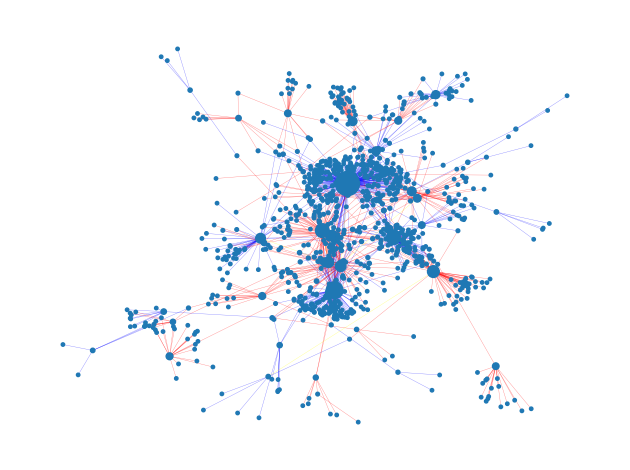

Generated outputs:
  PDF → proe_orthoe.pdf
  Gephi TSV → proe_orthoe.tsv
  Cytoscape GML → proe_orthoe.gml


In [ ]:
splitpea.plot("/content/proe_orthoe.edges.pickle", pdf_path ="proe_orthoe.pdf",  gephi_path ="proe_orthoe.tsv", cytoscape_path = "proe_orthoe.gml", self_edges = False, lcc = True)

#### 2.4 Example downstream analysis  

As an example, here we demonstrate a simple downstream analysis that highlights what Splitpea can reveal beyond standard SUPPA2 output.  

First, we examine the raw SUPPA2 file (`proe_orthoe.dpsi`) to count the total number of skipped exon (SE) events, the number of unique genes involved, and how many of those events and genes are significant at *p* < 0.05.  

Next, we compare these results to the Splitpea network statistics. Specifically, we ask whether there are genes with high connectivity (degree in the top 10% of the rewired network) that were **not** detected as significant by SUPPA2. These genes may represent cases whose interactions might be disrupted by spicing, even if the gene itself is not strongly differentially spliced.

In [ ]:
# File paths
dpsi_file = "/content/proe_orthoe.dpsi"       # SUPPA2 output (dowloaded from Github)
map_file  = "/content/hsa_mapping_all.txt"    # gene mapping file (downloaded from the "Install and import dependencies" section)

# Load SUPPA2 results and keep SE events only
dpsi_df = pd.read_csv(dpsi_file, sep="\t", index_col=0)
event_type = dpsi_df.index.to_series().str.extract(r';([^:]+):', expand=False)
dpsi_df = dpsi_df[event_type.eq("SE")].copy()

# Extract Ensembl gene IDs (strip version) and map to symbols
dpsi_df["ensembl"] = dpsi_df.index.str.split(";").str[0].str.split(".").str[0]
map_df = pd.read_csv(map_file, sep="\t", dtype=str)
ens2sym = (map_df[["ensembl", "symbol"]]
           .drop_duplicates("ensembl")
           .set_index("ensembl")["symbol"])
dpsi_df["symbol"] = dpsi_df["ensembl"].map(ens2sym)

# Count SE events and unique genes
print("Total number of SE events in SUPPA2:", len(dpsi_df))
print("Total number of unique genes in SUPPA2:", dpsi_df["symbol"].dropna().nunique())

# Identify significant events (p < 0.05)
alpha = 0.05
pval_col = "proe-orthoe_p-val"
sig_mask = dpsi_df[pval_col].astype(float) < alpha
print("Number of significant SE events in SUPPA2:", sig_mask.sum())
print("Number of unique significant genes in SUPPA2:",
      dpsi_df.loc[sig_mask, "symbol"].dropna().nunique())

# Extract set of significant genes (SUPPA2)
sig_genes_suppa = (
    dpsi_df.loc[sig_mask, "symbol"]
    .dropna()
    .unique()
)

# Compare with Splitpea results
no_common_sig = proe_orthoe_stats.loc[
    ~proe_orthoe_stats["symbol"].isin(sig_genes_suppa)
].copy()
print("Number of genes in Splitpea not significant in SUPPA2:", len(no_common_sig))

# Focus on top 10% by degree in Splitpea
degree_threshold = proe_orthoe_stats["degree"].quantile(0.9)
high_degree_genes_2 = no_common_sig[no_common_sig["degree"] >= degree_threshold]
print("Number of high-degree genes (top 10%) not significant in SUPPA2:", len(high_degree_genes_2))

high_degree_genes_2.head(10)


Total number of SE events in SUPPA2: 37432
Total number of unique genes in SUPPA2: 11313
Number of significant SE events in SUPPA2: 481
Number of unique significant genes in SUPPA2: 374
Number of genes in Splitpea not significant in SUPPA2: 1103
Number of high-degree genes (top 10%) not significant in SUPPA2: 48


,node,symbol,degree,normalized_degree,gain_count,loss_count,chaos_count
45,8031,NCOA4,6,1.000000,0,6,0
53,7316,UBC,5,0.013021,2,3,0
55,5071,PRKN,5,0.029940,2,3,0
59,8726,EED,4,0.074074,3,1,0
64,7314,UBB,4,0.019608,2,2,0
65,9212,AURKB,4,0.027586,2,2,0
70,4914,NTRK1,4,0.017699,2,2,0
72,9939,RBM8A,4,0.060606,2,2,0
74,1994,ELAVL1,3,0.015464,1,2,0
75,1107,CHD3,3,0.021277,0,3,0


We also performed gene set enrichment analysis (GSEA) using the [GSEApy](https://academic.oup.com/bioinformatics/article/39/1/btac757/6847088) package. Genes in the rewired network were ranked either by gain-edge count or by loss-edge count, with ties broken by normalized degree and then by raw degree. For each ranking, we tested enrichment against the GO Biological Process (2023) collection to identify pathways associated with genes gaining or losing many interactions.



In [ ]:
def build_prerank(stats_df, count_col):
    return (
        stats_df
        .dropna(subset=["symbol", count_col, "normalized_degree", "degree"])
        .sort_values(by=[count_col, "normalized_degree", "degree"], ascending=False)
        .assign(score=lambda df: (
            df.groupby([count_col, "normalized_degree", "degree"], sort=False)
              .ngroup()
              .pipe(lambda g: g.max() - g + 1)
        ))
        .loc[:, ["symbol", "score"]]
        .rename(columns={"symbol": "gene"})
    )

def run_gsea_prerank(rnk, gene_sets="GO_Biological_Process_2023", threads=10, seed=42):
    pre = gp.prerank(rnk=rnk, gene_sets=gene_sets, threads=threads, seed=seed, verbose=False)
    sig = pre.res2d.query("`FDR q-val` < 0.05").copy()
    nes_pos = sig[sig["NES"] > 0].copy()
    return pre, sig, nes_pos

gain_rnk = build_prerank(proe_orthoe_stats, "gain_count")
pre_gain_2, sig_gain_2, gain_results_2 = run_gsea_prerank(gain_rnk)

loss_rnk = build_prerank(proe_orthoe_stats, "loss_count")
pre_loss_2, sig_loss_2, loss_results_2 = run_gsea_prerank(loss_rnk)

print("Top GO BP (gain):")
display(gain_results_2)

print("Top GO BP (loss):")
display(loss_results_2)


2025-08-23 04:15:12,518 [WARNING] Duplicated values found in preranked stats: 67.23% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-08-23 04:15:20,467 [WARNING] Duplicated values found in preranked stats: 67.23% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Top GO BP (gain):


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes


Top GO BP (loss):


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
3,prerank,mRNA Processing (GO:0006397),0.539688,1.976613,0.0,0.008136,0.009,39/85,10.30%,HNRNPM;SNRPA1;EIF4A3;NCBP1;GEMIN6;SNRNP70;SNRP...
4,prerank,"RNA Splicing, Via Transesterification Reaction...",0.54319,1.974593,0.0,0.004068,0.009,36/77,10.30%,HNRNPM;SNRPA1;EIF4A3;NCBP1;GEMIN6;SNRNP70;SNRP...
5,prerank,Regulation Of RNA Splicing (GO:0043484),0.605678,1.956199,0.0,0.003315,0.011,14/26,12.98%,SNRNP70;POLR2A;SRSF3;HNRNPL;U2AF2;SRSF1;RBM39;...
6,prerank,RNA Processing (GO:0006396),0.537062,1.94355,0.0,0.003164,0.014,29/63,9.57%,SNRPA1;NCBP1;LSM1;SNRPD2;SNRPG;SNRPD1;SNRPF;SN...
7,prerank,"mRNA Splicing, Via Spliceosome (GO:0000398)",0.523127,1.919779,0.0,0.003616,0.019,69/89,41.93%,HNRNPM;SNRPA1;EIF4A3;NCBP1;GEMIN6;SNRNP70;DCPS...
8,prerank,U2-type Prespliceosome Assembly (GO:1903241),0.61816,1.909181,0.0,0.003917,0.023,10/19,7.22%,SNRPA1;SNRPD2;SNRPG;SNRPD1;SNRPF;SNRPB;SNRPE;S...
10,prerank,RNA Export From Nucleus (GO:0006405),0.624747,1.898234,0.0,0.004649,0.033,10/19,9.08%,EIF4A3;NCBP1;NUP160;UPF2;RBM8A;SRSF3;NCBP2;ALY...
11,prerank,mRNA Export From Nucleus (GO:0006406),0.632153,1.8908,0.0,0.00452,0.036,10/18,8.92%,EIF4A3;NCBP1;NUP160;UPF2;RBM8A;SRSF3;PABPN1;NC...
12,prerank,"Regulation Of mRNA Splicing, Via Spliceosome (...",0.558784,1.865487,0.0,0.006027,0.054,15/31,12.98%,NCBP1;RBM8A;SRSF3;RNPS1;SF3B4;SRSF7;HNRNPA0;HN...
13,prerank,Spliceosomal snRNP Assembly (GO:0000387),0.612966,1.855654,0.0,0.006418,0.064,16/18,33.90%,GEMIN6;SNRPD2;SNRPG;SNRPD1;SNRPF;SNRPB;LSM2;SN...


### 3. Questions? Feedback?

Please submit an issue through our [Github](https://github.com/ylaboratory/splitpea_package/issues) page.

#### PyPi repository

Want to try out Splitpea? Please download it from our PyPi repository: ...

#### Citations

...